# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join
from solver import Point, Facility, Customer, length, load_data
from vis import view_problem

In [3]:
path = 'data'
ls = os.listdir

In [4]:
# print(*ls(path),sep = '  ,  ')
for i,file in enumerate(ls(path)):
    customers, facilities = load_data(file)
    print(f'{file:15} {len(customers):6} Customers \t{len(facilities):6} Facilities')

fl_1000_2         1500 Customers 	  1000 Facilities
fl_1000_3         5000 Customers 	  1000 Facilities
fl_100_1          1000 Customers 	   100 Facilities
fl_100_10          100 Customers 	   100 Facilities
fl_100_11          500 Customers 	   100 Facilities
fl_100_12          500 Customers 	   100 Facilities
fl_100_13         1000 Customers 	   100 Facilities
fl_100_14          800 Customers 	   100 Facilities
fl_100_2          1000 Customers 	   100 Facilities
fl_100_3          1000 Customers 	   100 Facilities
fl_100_4          1000 Customers 	   100 Facilities
fl_100_5          1000 Customers 	   100 Facilities
fl_100_6           100 Customers 	   100 Facilities
fl_100_7           100 Customers 	   100 Facilities
fl_100_8           100 Customers 	   100 Facilities
fl_100_9           100 Customers 	   100 Facilities
fl_16_1             50 Customers 	    16 Facilities
fl_16_2             50 Customers 	    16 Facilities
fl_2000_2         2000 Customers 	  2000 Facilities
fl_2000_3   

In [82]:
customers, facilities = load_data('fl_50_1')
(customers, facilities)

([Customer(index=0, demand=146, location=Point(x=271151.005415, y=182500.375666)),
  Customer(index=1, demand=87, location=Point(x=271174.28298, y=182500.3671)),
  Customer(index=2, demand=672, location=Point(x=272653.448286, y=183068.675019)),
  Customer(index=3, demand=1337, location=Point(x=278615.098905, y=185792.50856)),
  Customer(index=4, demand=31, location=Point(x=271171.919808, y=182497.993964)),
  Customer(index=5, demand=559, location=Point(x=272088.833862, y=182850.845727)),
  Customer(index=6, demand=2370, location=Point(x=299498.08876, y=210542.997998)),
  Customer(index=7, demand=1089, location=Point(x=275150.105365, y=184336.62979)),
  Customer(index=8, demand=33, location=Point(x=271170.588171, y=182497.852906)),
  Customer(index=9, demand=32, location=Point(x=271172.866541, y=182498.087512)),
  Customer(index=10, demand=5495, location=Point(x=384981.479438, y=350758.465403)),
  Customer(index=11, demand=904, location=Point(x=273573.857303, y=183499.372217)),
  Custom

# Visualisation


In [83]:
from vis import view_problem, view_solution

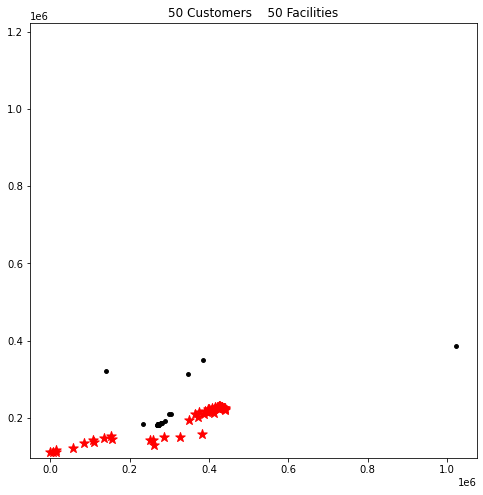

In [84]:
view_problem(customers,facilities)

In [95]:
sol = greedy(customers,facilities)

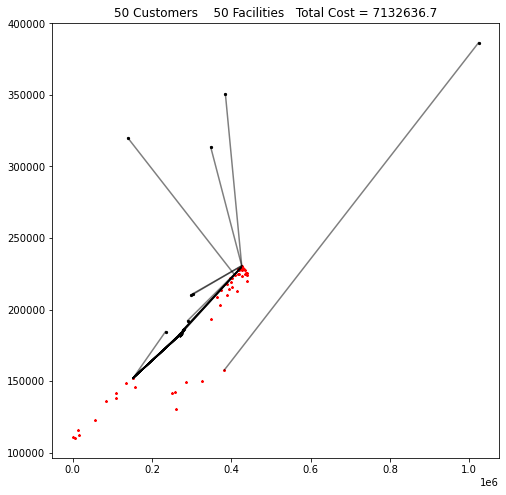

In [96]:
view_solution(sol,customers,facilities)

# Exploration

In [7]:
from calc import validate, total_cost

from algorithms import greedy
from exceptions import *

## Random allocation

In [48]:
from pdb import set_trace

In [79]:
from tqdm.auto import tqdm, trange
from joblib import Parallel, delayed


def random_allocation(customers, facilities):
    max_iter = 10000
    n_fac = len(facilities)
    allocations = -np.ones(len(customers))
    remaining_capacity = np.array([f.capacity for f in facilities])
    for i, customer in enumerate(customers):
        for counter in range(max_iter):
            selected_facility = np.random.choice(
                range(n_fac),
                p=remaining_capacity / remaining_capacity.sum(),
            )
            if remaining_capacity[selected_facility] >= customer.demand:
                remaining_capacity[selected_facility] -= customer.demand
                allocations[i] = selected_facility
                break
        else:
            raise IterationError('Maximum number of iterations reached.')
    return allocations.astype(int)


def ex_local_search(solution, customers, facilities, verbose=False):
    allocations = solution.copy()
    n_cutomers = len(customers)
    n_facilities = len(facilities)
    old_cost = total_cost(allocations, customers, facilities)
    pbar = trange(n_cutomers)
    for i in pbar:
        customer = customers[i]
        costs = np.zeros(n_facilities)
        old_alloc = allocations[i]
        for j in range(n_facilities):
            allocations[i] = j
            costs[j] = total_cost(allocations, customers, facilities)
        new_alloc = np.argmin(costs)
        allocations[i] = new_alloc
        if verbose:
            desc = '{:.1f} --> {:.1f} --> {:.1f}'.format(
                old_cost,
                costs[old_alloc],
                costs[new_alloc],
            )
            pbar.set_description(desc)
    return allocations


def ex_local_search_v2(solution, customers, facilities, verbose=False):
    allocations = solution.copy()
    n_cutomers = len(customers)
    n_facilities = len(facilities)
    old_cost = total_cost(allocations, customers, facilities)
    pbar = trange(n_cutomers)
    for i in pbar:
        customer = customers[i]
        costs = np.zeros(n_facilities)
        old_alloc = allocations[i]

        parallel = Parallel(n_jobs=-1)
        delayed_func = delayed(eval_swap_values)
        costs = parallel(
            delayed_func(
                allocations=allocations,
                customers=customers,
                facilities=facilities,
                customer=i,
                new_facility=j,
            ) for j in range(n_facilities))
#         for j in range(n_facilities):
#             allocations[i] = j
#             costs[j] = total_cost(allocations, customers, facilities)
        new_alloc = np.argmin(costs)
        allocations[i] = new_alloc
        if verbose:
            desc = '{:.1f} --> {:.1f} --> {:.1f}'.format(
                old_cost,
                costs[old_alloc],
                costs[new_alloc],
            )
            pbar.set_description(desc)
    return allocations


def eval_swap_values(allocations, customers, facilities, customer,
                     new_facility):
    alloc = allocations.copy()
    alloc[customer] = new_facility
    return total_cost(alloc, customers, facilities)

In [92]:
from algorithms import greedy

In [97]:
customers, facilities = load_data('fl_100_3')
len(customers),len(facilities)

(1000, 100)

In [98]:
# sol = random_allocation(customers,facilities)
sol = greedy(customers,facilities)
total_cost(sol,customers,facilities)

31281008.88594785

In [99]:
sol2 = ex_local_search_v2(sol,customers,facilities,True)

In [87]:
%debug

> <ipython-input-79-314b051d51d1>(79)ex_local_search_v2()
     77             desc = '{:.1f} --> {:.1f} --> {:.1f}'.format(
     78                 old_cost,
---> 79                 costs[old_alloc],
     80                 costs[new_alloc],
     81             )

ipdb> p costs
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
ipdb> len(costs)
50
ipdb> old_alloc
55
ipdb> q


In [135]:
sol = greedy(customers,facilities)
total_cost(sol,customers,facilities)

26090682.612702664

In [136]:
sol2 = local_search(sol,customers,facilities,True)

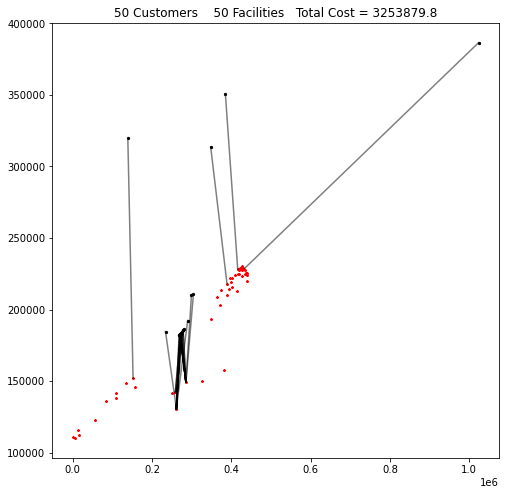

In [88]:
view_solution(sol2,customers,facilities)

In [141]:
validate(sol2,customers,facilities)

IndexError: list index out of range

## Constraint Programming

### Uncapacitated Facilities

In [174]:
from ortools.sat.python import cp_model
from calc import distance_matrix


In [146]:
customers,facilities= load_data('fl_100_1')
n_cust = len(customers)
n_fac = len(facilities)

In [164]:
caps = [f.capacity for f in facilities]
setup = [f.setup_cost for f in facilities]
dist = distance_matrix(customers,facilities).astype(int)
demands = [c.demand for c in customers]

In [147]:
model = cp_model.CpModel()

In [157]:
a = [] # allocation matrix (facilities x customers)
for f in range(n_fac):
    a.append([model.NewBoolVar(f'a_{c}_{f}') for c in range(n_cust)])

In [161]:
# Only one facility per customer
for c in range(n_cust):
    model.Add(sum([a[f][c] for f in range(n_fac)])==1)
    
# Capacity check
for f in range(n_fac):
    model.Add(sum([a[f][c]*demands[c] for c in range(n_cust)])<=caps[f])

In [165]:
obj = 0
for f in range(n_fac):
    for c in range(n_cust):
        obj+=a[f][c]*dist[f,c]

In [169]:
model.Minimize(obj)

In [170]:
cpsolver = cp_model.CpSolver()
cpsolver.parameters.max_time_in_seconds = 60.0
status = cpsolver.Solve(model)

In [175]:
STATUS = {
    cp_model.FEASIBLE: 'FEASIBLE',
    cp_model.UNKNOWN: 'UNKNOWN',
    cp_model.MODEL_INVALID: 'MODEL_INVALID',
    cp_model.INFEASIBLE: 'INFEASIBLE',
    cp_model.OPTIMAL: 'OPTIMAL',
}
STATUS[status]

'FEASIBLE'

In [176]:
values = [] # allocation matrix (facilities x customers)
for f in range(n_fac):
    values.append([cpsolver.Value(a[f][c]) for c in range(n_cust)])

values = np.array(values)

sol = values.argmax(axis=0)

In [183]:
total_cost(sol,customers,facilities)

135235944.1211516

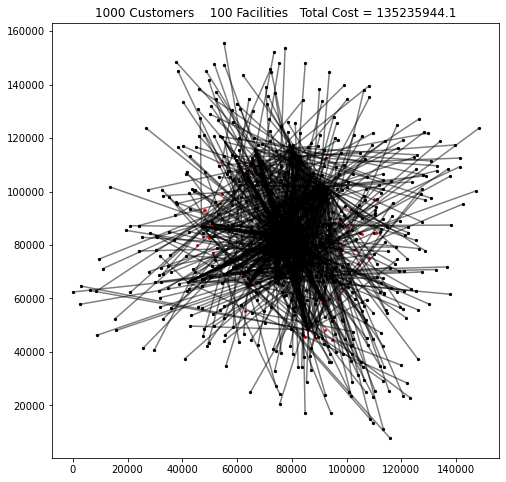

In [184]:
view_solution(sol,customers,facilities)

## Solve using clustering
Ignores the facility capital cost

In [34]:
import math
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from calc import total_demand, total_cost
from tqdm.auto import trange

In [115]:
q = [2,3,5,3,1]

In [118]:
np.cumsum(sorted(q))

array([ 1,  3,  6,  9, 14], dtype=int32)

In [35]:
def min_facilities(customers, facilities):
    caps = [f.capacity for f in facilities]
    cumsum = np.cumsum(sorted(caps))
    demands = [c.demand for c in customers]
    total_demand = sum(demands)
    for i in range(len(facilities)):
        if cumsum[i]>=total_demand:
            print(f'Demand = {total_demand}, Capacity = {cumsum[i]}')
            return i+1
    
#     return math.ceil(total_demand/max(caps))

In [124]:
min_facilities(customers,facilities)

Demand = 50886, Capacity = 56000


7

In [149]:
customers, facilities = load_data('fl_1000_2')
n_cust = len(customers)
n_fac = len(facilities)
n_cust,n_fac

(1500, 1000)

In [150]:
[f.setup_cost for f in facilities]

[7318.4413,
 8788.0676,
 6958.9546,
 7317.1473,
 7463.9433,
 8215.2332,
 8472.1128,
 7800.1308,
 7549.7209,
 7634.6868,
 7023.5005,
 8054.5313,
 7146.7849,
 8536.3318,
 7765.8439,
 7479.0865,
 7696.0054,
 7487.6366,
 8400.2561,
 7547.0541,
 5936.7847,
 7410.7603,
 6031.4033,
 6729.6004,
 6907.8929,
 7315.5894,
 7728.1385,
 8824.6747,
 8945.9629,
 8571.1894,
 7124.8496,
 6366.9881,
 7778.7831,
 7973.2498,
 9215.7196,
 10204.2127,
 8431.6108,
 7440.4777,
 8612.0897,
 7222.1362,
 7693.1352,
 8298.6762,
 9161.3766,
 8251.8567,
 5671.4989,
 9627.6421,
 7523.5505,
 6566.1433,
 8305.1937,
 5911.5744,
 8921.6063,
 9589.8285,
 7866.0065,
 7863.3453,
 7976.9514,
 7220.8324,
 9171.2199,
 7921.4981,
 7393.578,
 7855.6247,
 8449.0664,
 8535.4546,
 8547.932,
 7756.1375,
 6253.1041,
 8646.843,
 7957.0807,
 8206.611,
 7912.7118,
 6913.5608,
 8177.3486,
 8413.3635,
 6598.7556,
 8471.0153,
 7287.3686,
 7952.3163,
 8139.2582,
 7255.1942,
 8006.5592,
 8557.4951,
 7938.5343,
 7494.5364,
 7149.149,
 7258.93

In [75]:
# total_demand(customers)

In [76]:
# [f.capacity for f in facilities]

In [140]:
def clustering(customers, facilities):
    n_cust = len(customers)
    n_fac = len(facilities)
    
    # Find minimum number of clusters
    min_fac = min_facilities(customers,facilities)
    
    # Find cluster centroids
    kmean = KMeans(min_fac)
    xy = np.array([c.location for c in customers])
    kmean.fit(xy)
    centroids = kmean.cluster_centers_
    
    # Find the distance between facilities and centroids
    fneigh = KDTree(np.array([f.location for f in facilities]))
    dist, locs = fneigh.query(centroids,min_fac)
    
    # Match facilities with centroids
    inactive_facs = set(range(n_fac))
    active_facs = []
    for i in range(min_fac):
        for j in range(min_fac):
            if locs[i,j] in inactive_facs:
                inactive_facs = inactive_facs - {locs[i,j]}
                active_facs.append(locs[i,j])
                break
    
    # Assign facilities to customers
    turn = 0
    remaining_cap = [facilities[f].capacity for f in active_facs]
    remaining_cust = set(range(n_cust))
    max_iter = len(active_facs)*n_cust
    sol = -np.ones(n_cust,dtype=int)
    pbar = trange(n_cust)
    for _ in range(max_iter):
        turn +=1
        turn %=len(active_facs)
        turn_fac = active_facs[turn]
        kd_cust = KDTree(np.array([customers[c].location for c in list(remaining_cust)]))
        dist, pot_cust = kd_cust.query([facilities[turn_fac].location],1)
        pot_cust = list(remaining_cust)[pot_cust[0][0]]
        if remaining_cap[turn]<customers[pot_cust].demand:
            continue
        else:
            pbar.update()
            sol[pot_cust] = turn_fac
            remaining_cust = remaining_cust - {pot_cust}
            remaining_cap[turn]-=customers[pot_cust].demand
        if min(sol)>=0:
            break
    else:
        IterationError('Maximum number of iteration reached.')
    return sol

In [141]:
sol = clustering(customers,facilities)

Demand = 50886, Capacity = 56000


In [142]:
sol

array([80, 91, 24, 66, 80, 24, 51, 38, 38, 91, 91, 80, 80, 80, 27, 51, 38,
       80, 80, 91, 24, 80, 66, 80, 80, 80, 66, 51, 24, 38, 51, 91, 80, 91,
       27, 24, 27, 38, 51, 66, 27, 80, 24, 51, 66, 51, 24, 27, 27, 38, 51,
       80, 51, 24, 80, 80, 51, 91, 91, 24, 27, 38, 91, 38, 66, 27, 51, 27,
       51, 91, 27, 38, 24, 27, 27, 51, 91, 38, 51, 27, 38, 80, 24, 80, 24,
       66, 66, 66, 24, 51, 51, 24, 80, 91, 80, 27, 66, 38, 80, 51, 24, 80,
       51, 80, 51, 38, 27, 80, 91, 80, 24, 24, 38, 66, 51, 27, 51, 66, 51,
       80, 91, 38, 24, 38, 24, 91, 66, 27, 51, 24, 27, 66, 27, 80, 24, 38,
       51, 24, 27, 80, 51, 66, 24, 80, 91, 66, 91, 24, 80, 51, 91, 24, 38,
       38, 51, 80, 38, 51, 27, 80, 66, 38, 24, 27, 66, 80, 24, 80, 80, 38,
       24, 27, 38, 91, 38, 24, 38, 66, 24, 80, 27, 24, 24, 66, 38, 91, 38,
       66, 38, 38, 24, 27, 91, 91, 51, 51, 66, 38, 38, 51, 51, 51, 80, 24,
       66, 24, 91, 27, 66, 38, 51, 91, 51, 51, 80, 91, 80, 91, 80, 91, 66,
       66, 66, 27, 38, 51

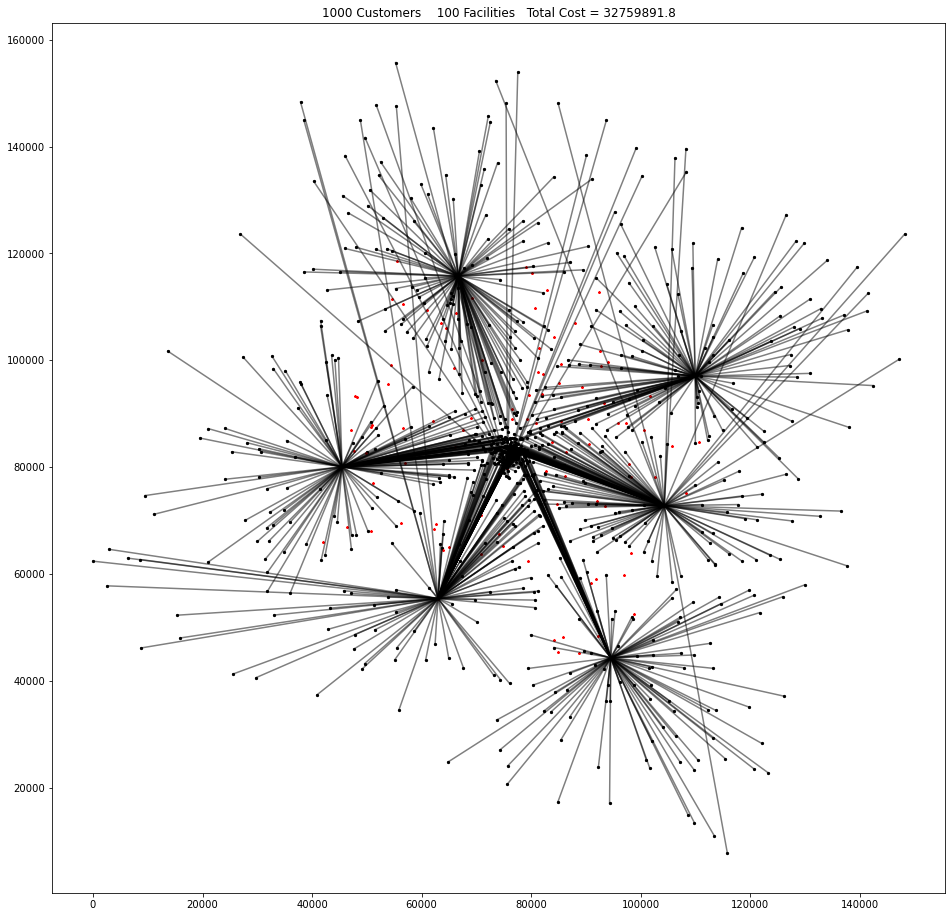

In [144]:
view_solution(sol,customers,facilities,(16,16))

## MIP

In [9]:
from ortools.linear_solver.pywraplp import Solver
from calc import distance_matrix,total_demand

In [60]:
customers, facilities = load_data('fl_100_7')
n_cust = len(customers)
n_fac = len(facilities)
n_cust,n_fac

(100, 100)

In [61]:
total_demand(customers)

305

In [62]:
min_facilities(customers,facilities)

Demand = 305, Capacity = 305


1

### Define model and variables

In [63]:
solver = Solver.CreateSolver('FacilityLocation','SCIP')

In [64]:
x = []
y = []
for f in range(n_fac):
    y.append([solver.BoolVar(f'y_{f}_{c}') for c in range(n_cust)])
    x.append(solver.BoolVar(f'x_{f}'))

### Constraints

In [37]:
facilities = facilities[:7]

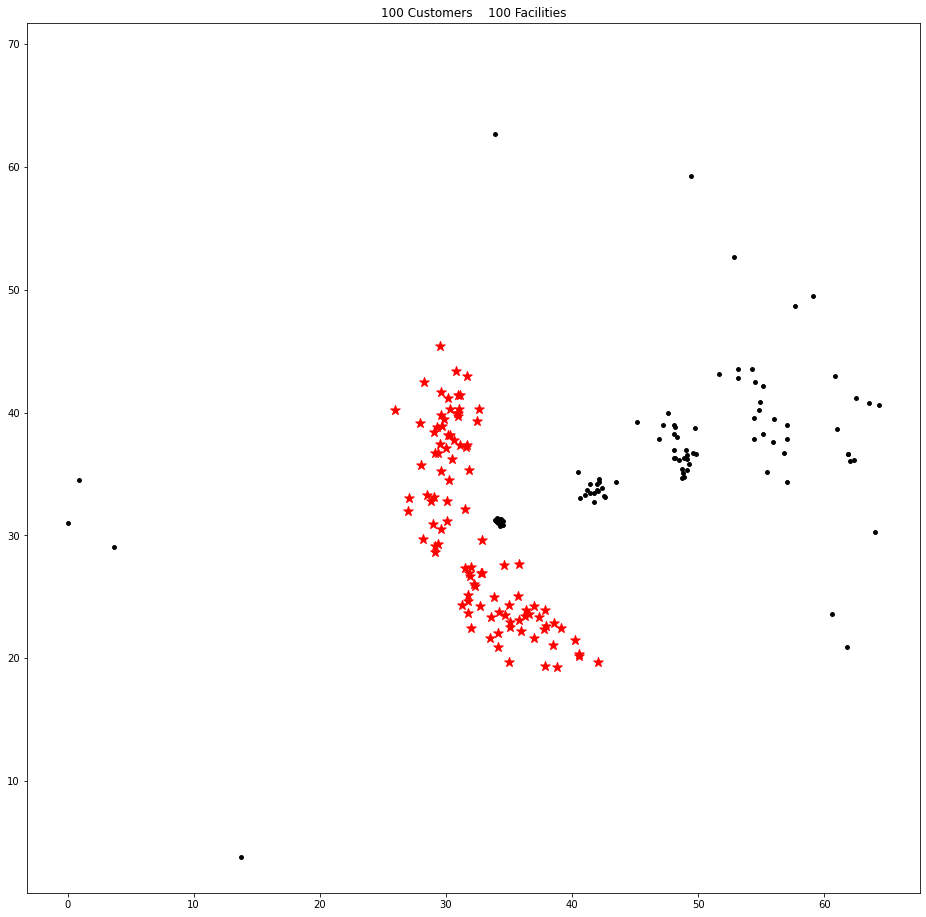

In [65]:
view_problem(customers,facilities,(16,16))

In [66]:
caps = [f.capacity for f in facilities]
setup = [f.setup_cost for f in facilities]
dist = distance_matrix(customers,facilities).astype(int)
demands = [c.demand for c in customers]

In [67]:
n_fac=len(facilities)

In [68]:
for f in range(n_fac):
    for c in range(n_cust):
        solver.Add(y[f][c]<=x[f])
for c in range(n_cust):
    solver.Add(sum([y[f][c] for f in range(n_fac)])==1)
    
for f in range(n_fac):
    solver.Add(sum([y[f][c]*demands[c] for c in range(n_cust)])<=caps[f])

In [69]:
obj = 0
for f in range(n_fac):
    obj += setup[f]*x[f]
    obj += sum([dist[f][c]*y[f][c] for c in range(n_cust)])

In [70]:
solver.Minimize(obj)

In [71]:

STATUS = {
    Solver.FEASIBLE: 'FEASIBLE',
    Solver.UNBOUNDED: 'UNBOUNDED',
    Solver.BASIC: 'BASIC',
    Solver.INFEASIBLE: 'INFEASIBLE',
    Solver.NOT_SOLVED: 'NOT_SOLVED',
    Solver.OPTIMAL: 'OPTIMAL',
}
solver.SetTimeLimit(120000)

In [72]:
status = solver.Solve()
STATUS[status]

'FEASIBLE'

In [73]:
a = []
for f in range(n_fac):
    a.append([y[f][c].solution_value() for c in range(n_cust)])

In [74]:
sol = np.array(a).argmax(axis=0)

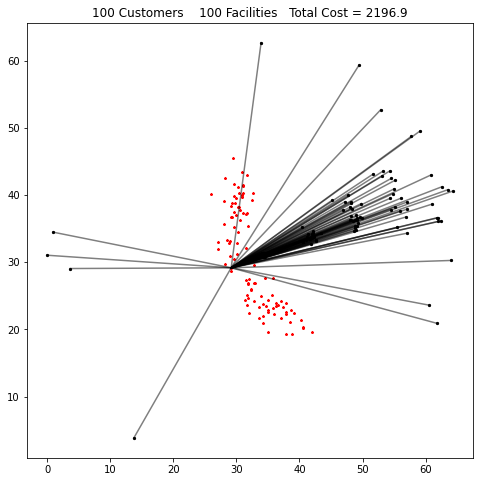

In [75]:
view_solution(sol,customers,facilities)

In [77]:
from calc import validate
validate(sol,customers,facilities)